# **<center> Similarity analysis of LMs' embeddings </center>**

## Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from scipy import stats

In [4]:
from scipy.spatial import distance

In [226]:
from matplotlib import rc
rc('text', usetex=True)

%config Completer.use_jedi = False

from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Loading

In [7]:
models = ['bert','bertLarge','gpt2','roberta','mpnet']
contexts = ['I come from', 'He lives in', 'She moved to']
short_ctxts = ['come','lives','moved']

In [8]:
cities = pd.read_csv('./csv/worldcitiespop.csv',header=0,dtype={'AccentCity':'str','Region':'object'}).dropna().drop('Region',axis=1)
cities = cities[cities.Population>100000].reset_index(drop=True)
cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
3,af,baglan,Baglan,108481.0,36.130684,68.708286
4,af,gardez,Gardez,103732.0,33.597439,69.225922
...,...,...,...,...,...,...
3522,zw,gweru,Gweru,201879.0,-19.450000,29.816667
3523,zw,harare,Harare,2213701.0,-17.817778,31.044722
3524,zw,kadoma,Kadoma,100276.0,-18.350000,29.916667
3525,zw,kwekwe,Kwekwe,116332.0,-18.916667,29.816667


In [9]:
#more than 500'000 citizens
big_cities = cities[cities.Population > 5e5]
big_cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
8,af,kabul,Kabul,3043589.0,34.516667,69.183333
16,am,yerevan,Yerevan,1093499.0,40.181111,44.513611
...,...,...,...,...,...,...
3499,za,soweto,Soweto,1695094.0,-26.267812,27.858492
3501,za,tembisa,Tembisa,511671.0,-25.996363,28.226802
3517,zm,lusaka,Lusaka,1267458.0,-15.416667,28.283333
3520,zw,bulawayo,Bulawayo,897249.0,-20.150000,28.583333


In [10]:
capitals = pd.read_csv('./csv/country-capitals.csv').drop(['ContinentName','CountryCode'], axis=1)
capitals

,CountryName,CapitalName,Latitude,Longitude
0,Somaliland,Hargeisa,9.550000,44.050000
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667
3,Palestine,Jerusalem,31.766667,35.233333
4,Aland Islands,Mariehamn,60.116667,19.900000
...,...,...,...,...
237,Zimbabwe,Harare,-17.816667,31.033333
238,Northern Cyprus,North Nicosia,35.183333,33.366667
239,Hong Kong,Hong Kong,22.302711,114.177216
240,British Indian Ocean Territory,Diego Garcia,-7.300000,72.400000


In [11]:
countries = pd.read_csv('./csv/countries.csv')
countries

,Name,Code,Latitude,Longitude
0,Afghanistan,AF,33.0000,65.0
1,Åland Islands,AX,60.1500,20.0
2,Albania,AL,41.0000,20.0
3,Algeria,DZ,28.0000,3.0
4,American Samoa,AS,-14.3333,-170.0
...,...,...,...,...
244,Wallis and Futuna,WF,-13.3000,-176.2
245,Western Sahara,EH,24.5000,-13.0
246,Yemen,YE,15.0000,48.0
247,Zambia,ZM,-15.0000,30.0


In [13]:
datasets = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_cities.npy')) for ctx in short_ctxts} for model_name in models}
datasets_capitals = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_capitals.npy')) for ctx in short_ctxts} for model_name in models}
datasets_countries = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_countries.npy')) for ctx in short_ctxts} for model_name in models}
contexts.append('average of 3')
short_ctxts.append('avg')
for model_name in models :
    concat = pd.concat( (datasets[model_name]['come'],datasets[model_name]['lives'],datasets[model_name]['moved']) )
    datasets[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_capitals[model_name]['come'],datasets_capitals[model_name]['lives'],datasets_capitals[model_name]['moved']) )
    datasets_capitals[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_countries[model_name]['come'],datasets_countries[model_name]['lives'],datasets_countries[model_name]['moved']) )
    datasets_countries[model_name]['avg'] = concat.groupby(concat.index).mean()


## Tools and functions

In [305]:
ctx = 'avg'

def cosine_sim(x,y):
    return 1-distance.cosine(x,y)

def createRSM(datasets,ctx='avg',source='cities'):
    for model in tqdm(models,desc='RSM'):
        X = datasets[model][ctx]
        dists = distance.pdist(X, metric=cosine_sim)
        rsm_arr = distance.squareform(dists)+np.diag(np.ones(len(X)))
        np.save(file='./rsm/'+model+'_'+source+'_RSM',arr=rsm_arr)

In [14]:
def flatten_triangle(arr):
    '''
    Return the flattened lower triangle of a symetric matrix
    '''
    return np.tril(arr).flatten()[(np.tril(arr,k=-1).flatten()>0 )]

In [50]:
def get_patch(rsm_arr,country1,country2):
    c1_filter = cities.Country==country1
    c2_filter = cities.Country==country2
    return rsm_arr[c1_filter,:][:,c2_filter]

## Similarity Matrix Analysis with cities

In [138]:
model = 'bertLarge'
rsm_arr = np.load('./rsm/'+model+'_cities_RSM.npy')

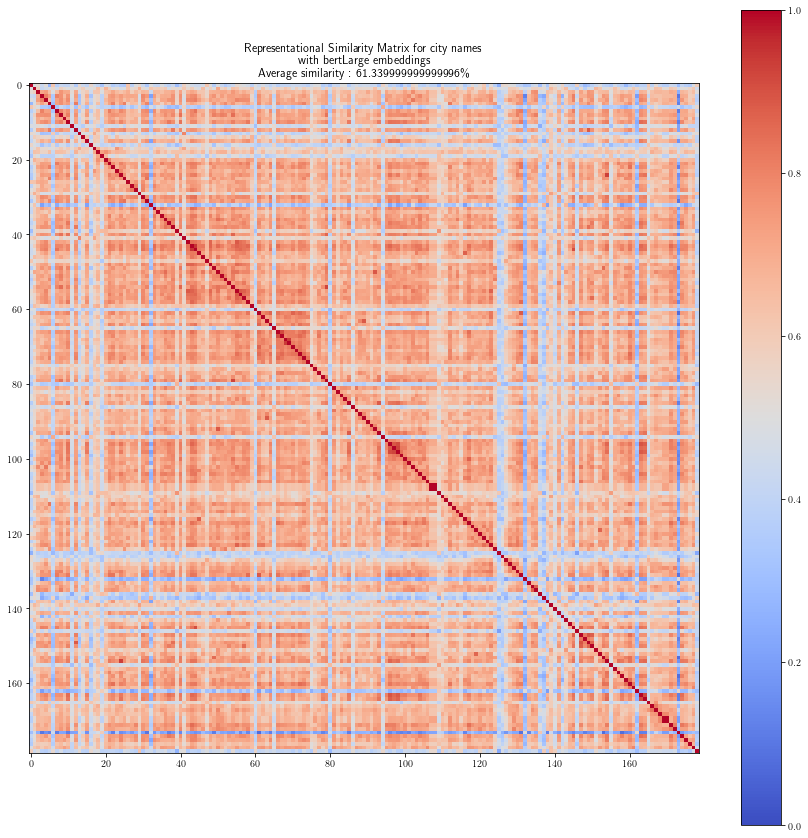

In [253]:
fig,ax=plt.subplots(1,figsize=(15,15))
fig.set_facecolor('white')
cut_arr = get_patch(rsm_arr,'jp','jp') # focus on 1 country compared to another
#cut_arr = rsm_arr #all countries
im = ax.imshow(cut_arr,vmin=0,vmax=1,cmap='coolwarm')
plt.colorbar(im)
plt.title('Representational Similarity Matrix for city names\n with '+model+' embeddings'+'\nAverage similarity : '+str(cut_arr.mean().round(4)*100)+'\%')
#plt.savefig('./img/RSM_'+model+'_cities.png',dpi=100,facecolor=fig.get_facecolor())
plt.show()

In [301]:
model = 'bertLarge'
rsm_arr = np.load('./rsm/'+model+'_cities_RSM.npy')

In [141]:
bins = 30
threshold_city_number = 5

hist_all_countries = np.histogram(flatten_triangle(rsm_arr),range=(0,1),density=True,bins=bins)

#countries_to_compare = ['cn','us','fr','es','in','ru','br','jp']
countries_to_compare = cities.Country.value_counts()[cities.Country.value_counts()>threshold_city_number].index

n = len(countries_to_compare)
all_hists = np.empty( (n*(n+1)//2,len(hist_all_countries[0])))
k = 0
for i,country in tqdm(enumerate(countries_to_compare),desc='All Countries',total=n,file=sys.stdout,leave=True):
    for j in range(i+1):
        cut_arr = get_patch(rsm_arr,country,countries_to_compare[j])
        hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
        all_hists[k] = hist[0]
        k+=1
all_mean_hist = np.mean(all_hists,axis=0)


intra_hists = np.empty( (n,len(hist_all_countries[0])))
for i,country in tqdm(enumerate(countries_to_compare),desc='Intra Country',total=n,file=sys.stdout,leave=True):
    cut_arr = get_patch(rsm_arr,country,country)
    hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
    intra_hists[i] = hist[0]
    #ax.plot(x_range,hist[0],label=country+' ; '+str(cut_arr.mean().round(2)))
intra_mean_hist = np.mean(intra_hists,axis=0)

inter_hists = np.empty( (n*(n-1)//2,len(hist_all_countries[0])))
k = 0
for i,country in tqdm(enumerate(countries_to_compare),desc='Inter Country',total=n,file=sys.stdout,leave=True):
    for j in range(i):
        cut_arr = get_patch(rsm_arr,country,countries_to_compare[j])
        hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
        inter_hists[k] = hist[0]
        k+=1
inter_mean_hist = np.mean(inter_hists,axis=0)


Inter Country: 100%|██████████| 78/78 [00:02<00:00, 26.24it/s]


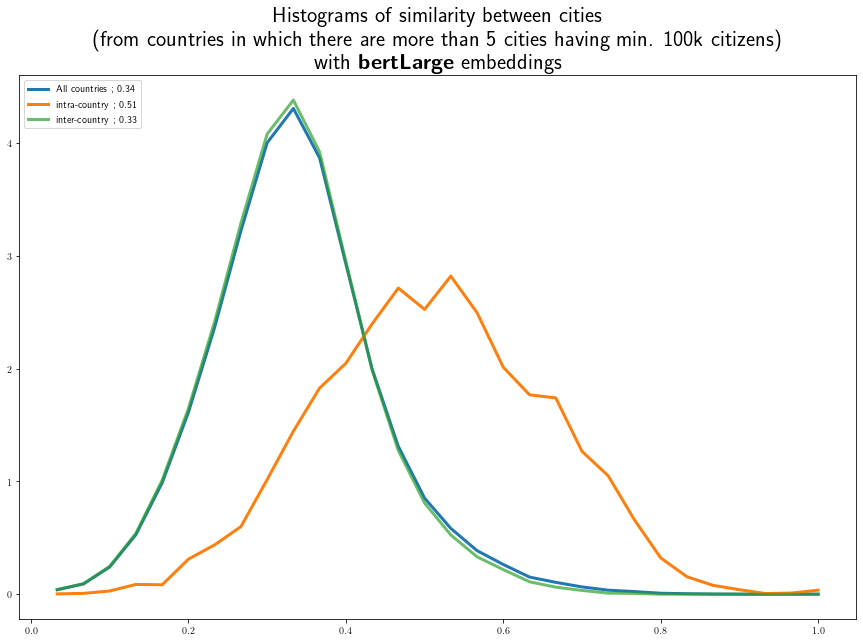

In [142]:
fig,ax = plt.subplots(1,figsize=(15,10))
fig.set_facecolor('white')

width = hist_all_countries[1][0]-hist_all_countries[1][0]
x_range = hist_all_countries[1][1:]+(width/2)

ax.plot(x_range,all_mean_hist,label = 'All countries ; '+str((all_mean_hist*x_range).mean().round(2)),lw=3)
ax.plot(x_range,intra_mean_hist,label = 'intra-country ; '+str((intra_mean_hist*x_range).mean().round(2)),lw=3)
ax.plot(x_range,inter_mean_hist,label = 'inter-country ; '+str((inter_mean_hist*x_range).mean().round(2)),lw=3,alpha=0.7)


plt.title('Histograms of similarity between cities \n(from countries in which there are more than '+str(threshold_city_number)
          +' cities having min. 100k citizens)\nwith '+r'\textbf{'+model+'} embeddings',fontdict = {'fontsize' : 22})
plt.legend(loc='upper left')
plt.savefig('./img/SimHist_'+model+'_cities.png',dpi=100,facecolor=fig.get_facecolor())
plt.show()

In [302]:
threshold_city_number = 5
countries_to_compare = cities.Country.value_counts(sort=False)[cities.Country.value_counts(sort=False)>threshold_city_number].index.sort_values()
n = len(countries_to_compare)

sim_countries = np.empty( (n,n) )

for i,country in tqdm(enumerate(countries_to_compare),desc='All Countries',total=n,file=sys.stdout,leave=True):
    for j in range(i+1):
        cut_arr = get_patch(rsm_arr,country,countries_to_compare[j])
        sim_countries[i][j] = cut_arr.mean()
        sim_countries[j][i] = cut_arr.mean()

All Countries: 100%|██████████| 78/78 [00:02<00:00, 28.43it/s] 


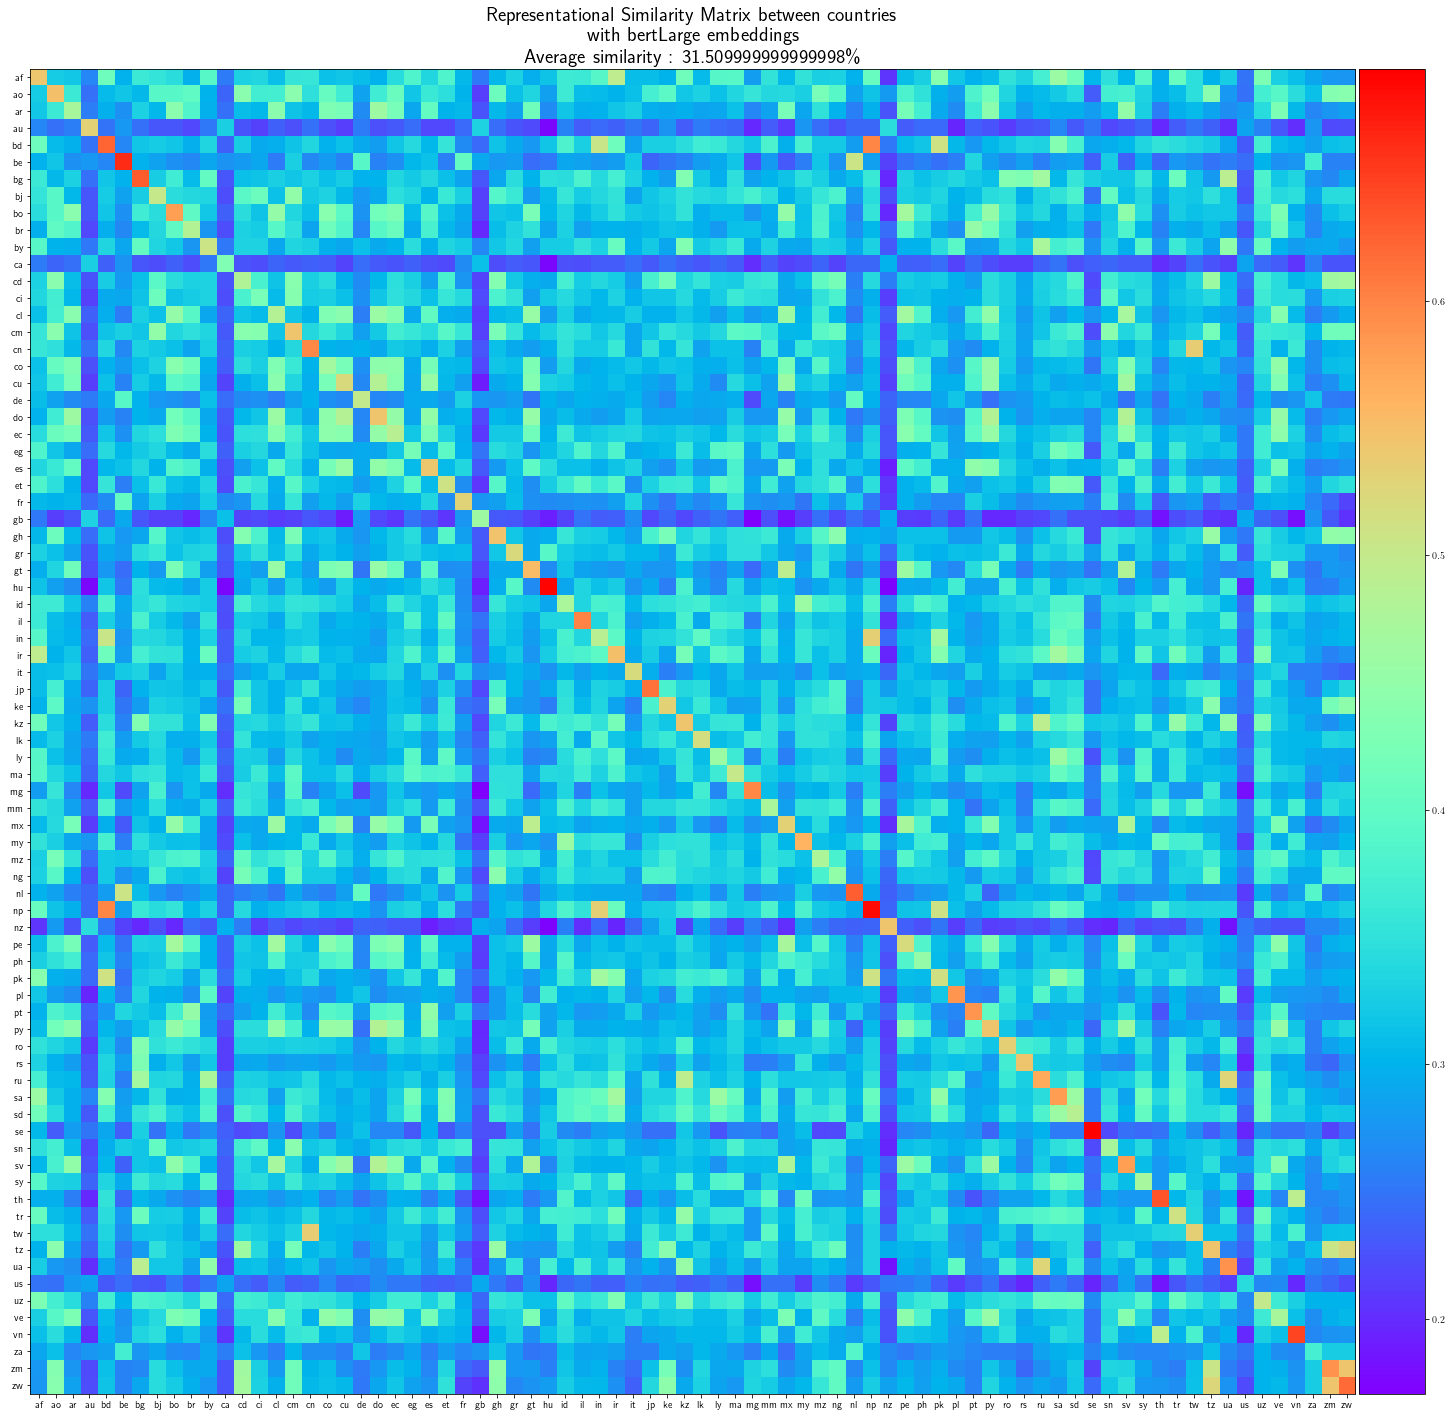

In [303]:
fig,ax=plt.subplots(1,figsize=(25,25))
fig.set_facecolor('white')

im = ax.imshow(sim_countries,vmin=sim_countries.min(),vmax=sim_countries.max(),cmap='rainbow')

plt.xticks(range(n),countries_to_compare)
plt.yticks(range(n),countries_to_compare)
plt.title('Representational Similarity Matrix between countries\n with '+model+' embeddings'+'\nAverage similarity : '
          +str(sim_countries.mean().round(4)*100)+'\%',fontdict={'fontsize':20})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.savefig('./img/RSM_'+model+'_cities_(by_country).png',dpi=200,facecolor=fig.get_facecolor())
plt.show()

## Similarity Matrix Analysis with country names

In [307]:
model = 'bertLarge'
rsm_arr = np.load('./rsm/'+model+'_countries_RSM.npy')

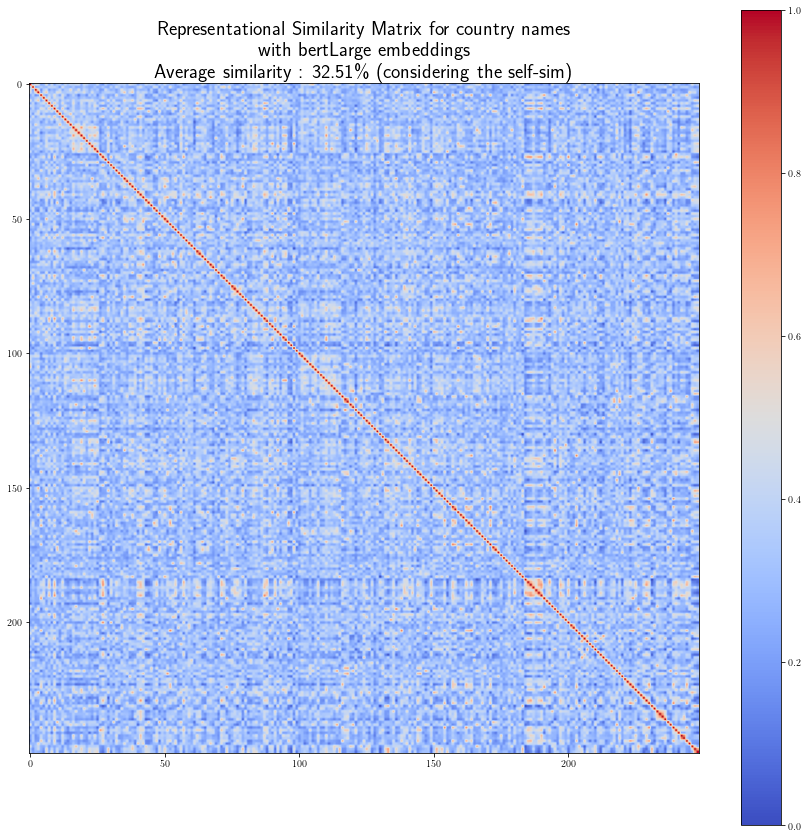

In [322]:
fig,ax=plt.subplots(1,figsize=(15,15))
fig.set_facecolor('white')
im = ax.imshow(rsm_arr,vmin=0,vmax=1,cmap='coolwarm')
plt.colorbar(im)
plt.title('Representational Similarity Matrix for country names\n with '+model+' embeddings'+'\nAverage similarity : '
          +str(rsm_arr.mean().round(4)*100)+'\% (considering the self-sim)',fontdict={'fontsize':20})
plt.savefig('./img/RSM_'+model+'_countries.png',dpi=100,facecolor=fig.get_facecolor())
plt.show()

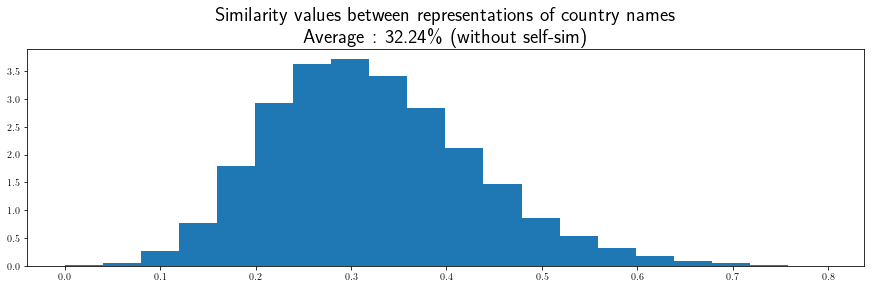

In [323]:
fig,ax = plt.subplots(1,figsize=(15,4))
fig.set_facecolor('white')

flat_rsm = flatten_triangle(arr=rsm_arr)
hist = ax.hist(flat_rsm,density=True,bins=20)

plt.title('Similarity values between representations of country names \nAverage : '+str(flat_rsm.mean().round(4)*100)+'\% (without self-sim)',fontdict={'fontsize':20})
plt.show()